# Natural Language Processing of Stack Exchange Community

The Stack Exchange Community is a platform to ask technical questions, discuss and exchange best practices. The most famous sub-page is STACKOVERFLOW with over 200 million visits each month. All of the data is publicly available for download and thus perfect for some analysis. In this notebook we will have a look at the UX / UI Community. Most of the script should also work for other communities, making it easy to transfer this code on other data. In this script, I would like to do two steps in specific:

First we will explore the data and do some visualization to see trends, common topics etc.

Second we are trying to predict the success of a question, i.e. how good is a a question asked (topic, style etc.)

<img src="stackexchange/stackexchange_overview.png" style="width:600px" />

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
np.random.seed(42)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(listdir("stackexchange/input"))

# read csv (comma separated value) into data
data = pd.read_csv('stackexchange/input/Posts_a.csv')
print('Data loaded')


Data loaded


C:\Users\Johannes\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
print('First glimpse at the data:')
data.head()
#data.info()
#data.describe()

First glimpse at the data:


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,1,1,13.0,NaN,2010-08-09 19:41:42,NaN,31,5746.0,<p>I've read suggestions that contextual menu ...,17654.0,...,NaN,2012-08-24 15:54:51,2018-07-17 19:51:47,Are radial contextual menus better than vertic...,<contextual-menu><radial-menu>,10.0,2,12.0,NaN,NaN
1,2,1,4.0,NaN,2010-08-09 19:42:31,NaN,25,8829.0,<p>When I have to load new information from my...,27.0,...,NaN,2010-08-09 19:49:55,2011-04-04 13:10:14,What is an acceptable response time for my aja...,<performance><response-time><ajax>,4.0,1,10.0,NaN,NaN
2,3,2,NaN,2.0,2010-08-09 19:45:42,NaN,30,NaN,<p>I guess this should follow the classic usab...,31.0,...,NaN,NaN,2010-08-09 19:45:42,NaN,NaN,NaN,6,NaN,NaN,NaN
3,4,2,NaN,2.0,2010-08-09 19:45:55,NaN,15,NaN,<p>I've always been told that a delay of 100ms...,17654.0,...,NaN,2017-05-23 12:39:56,2010-08-09 19:45:55,NaN,NaN,NaN,5,NaN,NaN,NaN
4,5,2,NaN,2.0,2010-08-09 19:46:07,NaN,3,NaN,<p>The information should load as fast as poss...,12.0,...,NaN,NaN,2010-08-09 19:46:07,NaN,NaN,NaN,0,NaN,NaN,NaN


# TASK 1: Data analysis
Interesting topics:
- Which are the most discussed topics?
- How did the community develop over time (more questions, average answer time)?
- Who are the users (location, profession)?
- and a mix of those (e.g. how did the topics change over time)


# TASK 2: Prediction - How do I achieve a good answer?

## Intuiton and Brainstorming


<table style="float:left;margin:50px;margin-left:0;" >
    <tr><th>Good question:</th>
        <th>Bad question:</th>
        </tr>

<tr ><td><span ><p>- many views</p>
<p>- many answers</p>
<p>- long answers (answers with images, text etc)</p>
<p>- many upvotes</p>
<p>- many marked as favorite </p>
<p>- question was answered </p>
<p>- discussed for long time</p>
<p>- example:</p></span>
    </td><td><p>- no answer, only comments </p>
<p>- negative upvotes</p>
    <p>-  <a href="https://ux.stackexchange.com/questions/127934/two-scroll-bars">example</a></p></td>
    </tr>

</table>


<a href="https://ux.stackexchange.com/questions/1795/when-to-use-icons-vs-icons-with-text-vs-just-text-links"><img src="stackexchange/example_good.png" style="width:600px;margin:50px;margin-left:0;" /></a>


Question style:
- length
- heading
- wording
- topics
- hashtags
- includes images, code


## Data Preprocessing / Cleaning
- cleaning html syntax with a regex function
- ...

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

In [41]:
# Formatting
data.CreationDate = pd.to_datetime(data.CreationDate)
data.LastActivityDate = pd.to_datetime(data.LastActivityDate)

# Convert to categorical
data.PostTypeId = data.PostTypeId.astype('category') 

# Handle NaN values
data.FavoriteCount = data.FavoriteCount.fillna(0)

print('Standard preprocessing done')

Standard preprocessing done


In [42]:
import re

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# convert column to String and use map function to apply "clean function"
data['Body'] = data['Body'].astype(str)
data['BodyNoHtml'] = data['Body'].map(cleanhtml)

print('New column of question content without HTML code created. Example:\n')
print('Body: ',data['Body'][1])
print('BodyNoHtml: ',data['BodyNoHtml'][1])

New column of question content without HTML code created. Example:

Body:  <p>When I have to load new information from my web server via ajax after a user action, how fast should the information be displayed for the user in order to be a good working UI for the user?</p>

BodyNoHtml:  When I have to load new information from my web server via ajax after a user action, how fast should the information be displayed for the user in order to be a good working UI for the user?



In [43]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import nltk
#nltk.download('wordnet')

# lematize and stem functions
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result



#preprocess
print('Content data lemmatized and stemmed. Example: \n')
data['BodyProcessed'] = data['BodyNoHtml'].map(preprocess)
print('BodyNoHtml: ',data['BodyNoHtml'][1])
print('BodyProcessed: ',data['BodyProcessed'][1])

Content data lemmatized and stemmed. Example: 

BodyNoHtml:  When I have to load new information from my web server via ajax after a user action, how fast should the information be displayed for the user in order to be a good working UI for the user?

BodyProcessed:  ['load', 'inform', 'server', 'ajax', 'user', 'action', 'fast', 'inform', 'display', 'user', 'order', 'good', 'work', 'user']


# Feature Engineering

In [44]:
import datetime as dt

# Subset of questions only (without their answers)
data_questions = data[data['PostTypeId']==1]
#data_questions['AcceptedAnswerId'][:20]

# Flag ob Frage vom Author als beantwortet gekennzeichnet wurde
#data_questions['QuestionSolved'] = data_questions['AcceptedAnswerId'].apply(lambda x: False if x >> 0 else True)
data_questions['QuestionSolved'] = np.where(data_questions.AcceptedAnswerId.isnull(), False, True)

# Time on which question was created
data_questions.loc[(data_questions.CreationDate.dt.hour < 25) & (data_questions.CreationDate.dt.hour  > 17), 'TimeCreatedCategorial'] = 'Evening'
data_questions.loc[(data_questions.CreationDate.dt.hour <= 17) & (data_questions.CreationDate.dt.hour  > 10), 'TimeCreatedCategorial'] = 'Day'
data_questions.loc[(data_questions.CreationDate.dt.hour <= 10) & (data_questions.CreationDate.dt.hour  > 4), 'TimeCreatedCategorial'] = 'Morning'
data_questions.loc[(data_questions.CreationDate.dt.hour <= 4) & (data_questions.CreationDate.dt.hour  >= 0), 'TimeCreatedCategorial'] = 'Evening'
data_questions.TimeCreatedCategorial = data_questions.TimeCreatedCategorial.astype('category')
# one hot encode
one_hot = pd.get_dummies(data_questions['TimeCreatedCategorial'])
data_questions = data_questions.drop('TimeCreatedCategorial',axis = 1)
data_questions = data_questions.join(one_hot)

# Flag if question was edited 
data_questions['QuestionEdited'] = np.where(data_questions.LastEditorDisplayName.isnull(), False, True)

# Time between CreationDate and LastActivityDate
data_questions['TimeActive'] = data_questions.LastActivityDate - data_questions.CreationDate

# Length of Title (unit: characters)
data_questions['LengthOfTitle'] = data_questions['Title'].apply(lambda x: len(x))

# Length of Body (unit: characters)
data_questions['LengthOfBody'] = data_questions['Body'].apply(lambda x: len(x))

# Number of Tags '<'
def count(text, keyletter):
    counter = 0
    for letter in text:
        if keyletter == letter:
            counter+=1
    return counter

data_questions['NumberOfTags'] = data_questions.Tags.apply(lambda x: count(x, '<'))

# Count of question marks 
data_questions['NumberOfQuestionsAsked'] = data_questions.Title.apply(lambda x: count(x,'?')) + data_questions.Body.apply(lambda x: count(x,'?'))

# How much formating used (bold, lists, yellow quotes, grey code, links, ..)
# <blockquote> <ul> <strong> <a href= <img src= <em> <code>
def countList(text, list):
    wordscount = 0
    for word in list:
        wordscount += text.count(word)
    return wordscount

formattingWords = {'<blockquote>','<ul>','<strong>','<a href=','<img src=','<em>','<code>'}
data_questions['NumberOfFormating'] = data_questions.Body.apply(lambda x: countList(x, formattingWords))

# Number of Answers
# -> AnswerCount
# approach would be with groupy.sum # print(data_questions.groupby('FavoriteCount')['AnswerCount'].mean())


# Rating (question is good when it has more than average ViewCount & FavoriteCount, very good -> 75, okay -> 25, bad -> 0)
ViewCount75 = np.quantile(data_questions.ViewCount, 0.75)
FavoriteCount75 = np.quantile(data_questions.FavoriteCount, 0.75)
#print(ViewCount75, FavoriteCount75)
ViewCount50 = np.quantile(data_questions.ViewCount, 0.5)
FavoriteCount50 = np.quantile(data_questions.FavoriteCount, 0.5)
ViewCount25 = np.quantile(data_questions.ViewCount, 0.25)
FavoriteCount25 = np.quantile(data_questions.FavoriteCount, 0.25)
data_questions.loc[:, 'Rating'] = 'Bad'
data_questions.loc[(data_questions.ViewCount > ViewCount25) & (data_questions.FavoriteCount > FavoriteCount25), 'Rating'] = 'Average'
data_questions.loc[(data_questions.ViewCount > ViewCount50) & (data_questions.FavoriteCount > FavoriteCount50), 'Rating'] = 'Good'
data_questions.loc[(data_questions.ViewCount > ViewCount75) & (data_questions.FavoriteCount > FavoriteCount75), 'Rating'] = 'Top'
# data_questions.loc[(data_questions.ViewCount > ViewCount25), 'Rating'] = 'Average'
# data_questions.loc[(data_questions.ViewCount > ViewCount50), 'Rating'] = 'Good'
# data_questions.loc[(data_questions.ViewCount > ViewCount75), 'Rating'] = 'Top'
data_questions.Rating = data_questions.Rating.astype('category')

## Backlog:

# important topic 

# level of language

# Experienced OwnerUserId or novice

# Weekday 

#data_questions[:5]
print('New features: ')
data_questions.loc[0:8,'QuestionSolved':'Rating']


C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Johannes\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

New features: 


,QuestionSolved,Day,Evening,Morning,QuestionEdited,TimeActive,LengthOfTitle,LengthOfBody,NumberOfTags,NumberOfQuestionsAsked,NumberOfFormating,Rating
0,True,0,1,0,False,2899 days 00:10:05,60,543,2,3,0,Top
1,True,0,1,0,False,237 days 17:27:43,51,197,3,2,0,Top
5,True,0,1,0,False,1844 days 07:13:20,106,579,1,4,0,Good
7,True,0,1,0,False,984 days 07:53:21,70,143,1,2,0,Top


In [45]:
import inspect

# to inspect the source code of a function
#print(inspect.getsource(np.average))

print('Let\'s check how our new feature "Rating" performed:')
data_questions.Rating.value_counts()

data_questions.groupby('Rating').mean()

Let's check how our new feature "Rating" performed:


,Id,AcceptedAnswerId,ParentId,DeletionDate,Score,ViewCount,OwnerUserId,LastEditorUserId,AnswerCount,CommentCount,...,QuestionSolved,Day,Evening,Morning,QuestionEdited,LengthOfTitle,LengthOfBody,NumberOfTags,NumberOfQuestionsAsked,NumberOfFormating
Rating,,,,,,,,,,,,,,,,,,,,,
Average,19458.063007,19527.010557,NaN,NaN,6.291329,1582.959451,10794.651505,8145.784535,3.373674,2.173425,...,0.650031,0.398004,0.385527,0.216469,0.001248,55.315034,897.360574,2.706800,2.425452,2.102932
Bad,21817.128447,21413.010561,NaN,NaN,3.431063,718.322885,12120.808654,8821.931537,2.502946,1.929060,...,0.580250,0.384162,0.395004,0.220834,0.002357,56.106293,847.750648,2.581428,2.322178,1.877445
Good,18726.238095,19420.104524,NaN,NaN,10.002165,2331.998918,10064.145251,8810.629526,4.162338,2.494589,...,0.693723,0.392857,0.396104,0.211039,0.000000,54.957792,971.506494,2.797619,2.576840,2.506494
Top,17407.306467,17879.855128,NaN,NaN,31.099344,12104.479850,9034.911565,10923.432526,6.746017,4.253983,...,0.731022,0.386129,0.383318,0.230553,0.000937,53.679475,921.592315,2.913777,2.652296,2.546392


ViewCount and AnswerCount show a good distribution, but lets replace the manual discretizing with unsupervised clustering.

Additionally we can already estimate some interesting correlations, e.g. look at Day/Evening/Morning, NumberOfTags, NumberOfFormating (are those significant enough?)

while others dont seem to have a lot of impact: LengthOfTitle, LengthOfBody

In [46]:
# kmeans clustering
from sklearn.cluster import KMeans

print('Kmeans on AnswerCount column:')
X = np.array(data_questions.AnswerCount).reshape(-1, 1)
kmeans = KMeans(n_clusters=4).fit(X)
print('Labels: ',kmeans.labels_)
print(kmeans.cluster_centers_)

print('\nKmeans on AnswerCount and ViewCount column:')
X = data_questions[['AnswerCount','ViewCount']]
kmeans = KMeans(n_clusters=4).fit(X)
print('Labels: ',kmeans.labels_)
print(kmeans.cluster_centers_)

Kmeans on AnswerCount column:
Labels:  [1 2 2 ... 0 0 0]
[[ 1.9798995 ]
 [ 8.74020319]
 [ 4.68628382]
 [20.09090909]]

Kmeans on AnswerCount and ViewCount column:
Labels:  [0 0 0 ... 0 0 0]
[[3.25006690e+00 1.36328713e+03]
 [1.18285714e+01 8.68002857e+04]
 [1.30000000e+01 4.81280000e+05]
 [7.19877676e+00 2.12448838e+04]]


# EDA

Task 1:
- Which are the most discussed topics?
- How did the community develop over time (more questions, average answer time)?
- Who are the users (location, profession)?
- and a mix of those (e.g. how did the topics change over time)

In [47]:
#1
# we use the tags column and count the most frequent tokens

# Tokenization
# lematize and stem functions are ignored as tags are already without stopwords and in base form
def tokenize(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(token)
    return result

tokenized_tags = data_questions.Tags.map(tokenize)

# Count word frequency
from collections import Counter

bow_simple = Counter()
for i in range(0, len(tokenized_tags)):
    bow_simple.update(tokenized_tags.tolist()[i])

print(bow_simple.most_common(25))

[('design', 2606), ('usability', 1000), ('website', 953), ('forms', 705), ('user', 603), ('gui', 562), ('web', 525), ('mobile', 521), ('interaction', 440), ('navigation', 421), ('buttons', 383), ('app', 361), ('behavior', 341), ('layout', 317), ('patterns', 312), ('search', 285), ('icons', 255), ('research', 239), ('input', 221), ('menu', 214), ('tables', 211), ('android', 208), ('color', 202), ('testing', 197), ('lists', 194)]


In [48]:
# from gensim.corpora import Dictionary

# columns = np.array(bow_simple.most_common(5))
# columns = [columns[:,0].tolist()] # [['design', 'usability', 'website', 'forms', 'user']]

# col_dictionary = Dictionary(columns)
# corpus = [col_dictionary.doc2bow(token) for token in tokenized_tags]
# # Print the first 10 word ids with their frequency counts from the fifth document
# print(col_dictionary)
# print(tokenized_tags[19])
# print(corpus[19][:10])


In [49]:
columns = np.array(bow_simple.most_common(20))
columns = columns[:,0].tolist() # e.g. ['design', 'usability', 'website', 'forms', 'user']

df_commontags = []
for token in tokenized_tags:
    row = []
    for column in columns:
        bool = 0
        if column in token:
            bool = 1
        row.append(bool)
    df_commontags.append(row)

df_commontags = pd.DataFrame(df_commontags, columns=columns)

data_questions_indexreset = data_questions.reset_index(drop=True)
df_commontags = pd.merge(data_questions_indexreset[['CreationDate','Tags']], df_commontags, left_index=True, right_index=True)
#df_commontags            

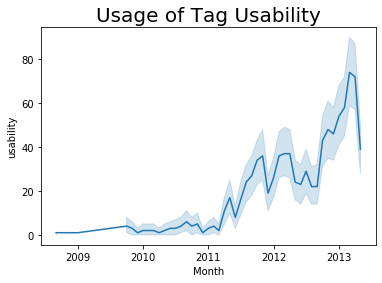

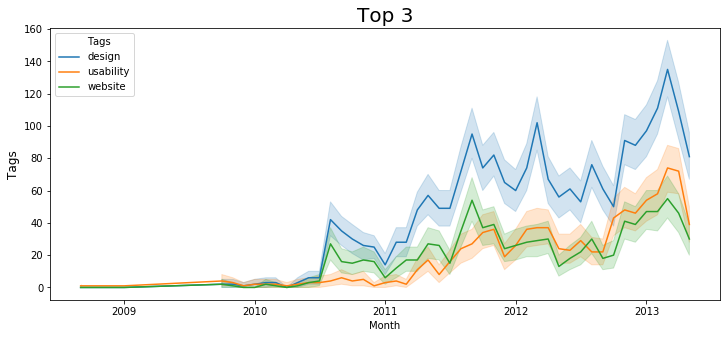

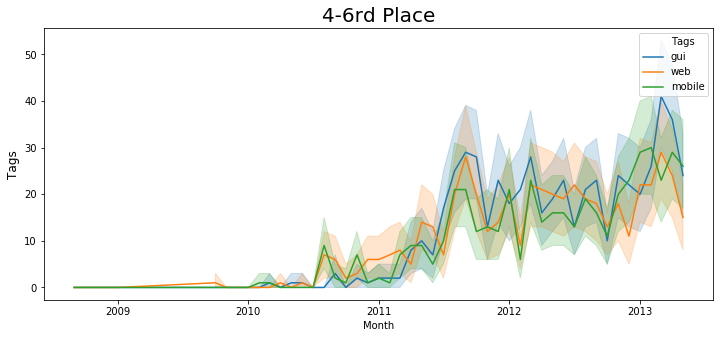

In [59]:
# visualization

# aggregate to month and year e.g. 2010-08-09 19:41:42 -> 2010-08-01
df_commontags.CreationDate = pd.to_datetime(df_commontags.CreationDate)
df_commontags['Month'] = df_commontags['CreationDate'].values.astype('datetime64[M]')
df_commontags
#df_commontags.to_csv('topics_by_month.csv', sep=',')

ax = sns.lineplot(x=df_commontags.Month, y="usability", data=df_commontags, estimator=sum)
plt.title("Usage of Tag Usability", fontsize = 20)
plt.show()

plt.figure(figsize=(12, 5))
df_plot = df_commontags[['design','usability','website','Month']].melt('Month', var_name='Tags',  value_name='vals')
ax = sns.lineplot(x='Month', y="vals", data=df_plot, hue='Tags', estimator=sum)
plt.title("Top 3", fontsize = 20)
plt.ylabel("Tags", fontsize = 12)
plt.show()

# ax2 = sns.lineplot(x=df_commontags.Month, y="gui", data=df_commontags)
# ax2 = sns.lineplot(x=df_commontags.Month, y="web", data=df_commontags)
# ax2 = sns.lineplot(x=df_commontags.Month, y="mobile", data=df_commontags)
plt.figure(figsize=(12, 5))
df_plot = df_commontags[['gui','web','mobile','Month']].melt('Month', var_name='Tags',  value_name='vals')
ax = sns.lineplot(x='Month', y="vals", data=df_plot, hue='Tags', estimator=sum)
plt.title("4-6rd Place", fontsize = 20)
plt.ylabel("Tags", fontsize = 12)
plt.show()



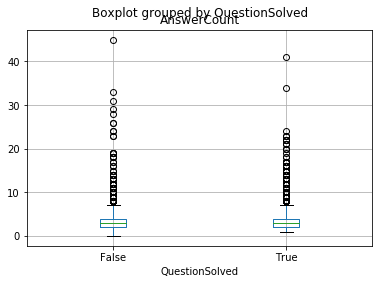

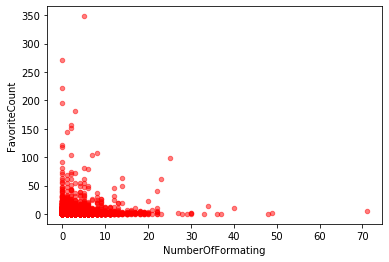

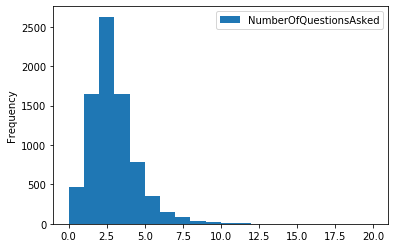

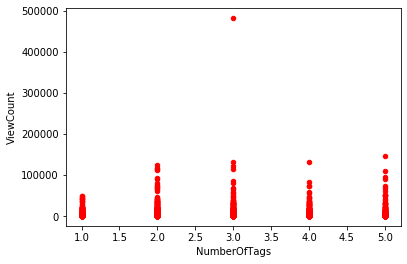

In [70]:
# score, view, answercount, commentcount, favoritecount
#data['AnswerCount'] = data['AnswerAount'].astype(int)
data_questions.boxplot(column = 'AnswerCount', by = 'QuestionSolved')

#sns.heatmap(data.corr())
#plt.show()

# Line Plot
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = grid, linestyle = sytle of line
# data.Speed.plot(kind = 'line', color = 'g')
# data.Defense.plot(color = 'r',label = 'Defense')
# plt.show()

# Scatter Plot 
data_questions.plot(kind='scatter', x='NumberOfFormating', y='FavoriteCount',alpha = 0.5,color = 'red')
# formating seems to be only a little bit important

# Histogram #bins = 50,
#data_questions.NumberOfFormating.plot(kind = 'hist',figsize = (4,4))
#plt.show()
# cumulative 
#data_questions.plot(kind = "hist",y = "AnswerCount",range= (0,8),normed = True,cumulative = True)
#plt.savefig('graph.png')
data_questions.plot(kind='hist', y = 'NumberOfQuestionsAsked', range=(0,20), bins=20)

data_questions.plot(kind='scatter', x='NumberOfTags', y='ViewCount',color = 'red')

# Modelling
## Classification

In [71]:
from sklearn.tree import DecisionTreeClassifier

# splitting data should be done before exploring and visualizing
# the data, to avoid choosing a model which fits test data
# to train model after restarting script with same train data, set seed!
# be careful if you get updated dataset, it will train on different indices
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

data_questions_train, data_questions_test = split_train_test(data_questions, 0.2)
print('Train: ',len(data_questions_train),' Test: ',len(data_questions_test))

# data standardization

# check numeric features for correlation

#'Body','Title','Tags','BodyNoHtml','BodyProcessed',
features = ['Day','Evening','Morning','NumberOfTags','NumberOfQuestionsAsked','NumberOfFormating','LengthOfTitle','LengthOfBody']
print("Features:", features, sep="\n")


X = data_questions[features]
y = data_questions.Rating

# use cross validation
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X, y)
print('Accuracy: ',tree_clf.score(X,y))

# check feature importance
#tree_clf.feature_importances_

# Train different models, SVM (different kernels), Neural Net, Random Forest, Regression

# optimize model with grid search


Train:  6270  Test:  1567
Features:
['Day', 'Evening', 'Morning', 'NumberOfTags', 'NumberOfQuestionsAsked', 'NumberOfFormating', 'LengthOfTitle', 'LengthOfBody']
Accuracy:  0.5467653438815874


# Documentation

### tree_clf = DecisionTreeClassifier(max_depth=5)
Features:
['Day', 'Evening', 'Morning', 'NumberOfTags', 'NumberOfQuestionsAsked', 'NumberOfFormating', 'LengthOfTitle', 'LengthOfBody']
0.5467653438815874

In [72]:
#Calculating Accuracy Score on test data
from sklearn.metrics import accuracy_score

test_predict = tree_clf.predict(data_questions_test[features])
accuracy_score(test_predict, data_questions_test['Rating'])

# retrain on complete dataset (create pipeline for preprocessing)

0.5341416719846841

In [73]:
# https://ux.stackexchange.com/questions/129084/is-320px-wide-designs-still-relevant-responsive-web
unseen_title = 'Is 320px wide designs still relevant? (responsive web)'
unseen_body = 'For a couple of years the smallest design I make for responsive websites is 375px wide. Now our new frontend developer eats my brain that I should provide 320px wide. And even if I will not she will scale to this minimum anyway. Smallest breakpoint is 480px. But the message is - good old 320px must be covered and scaling 375->320 is annoying (can\'t argue with latest thou). I tried to ask Google, and got an article "Why your mobile site should still stay 320px wide" dated 2012... Should we, still, in 2019? Need reasoned opinions. Current project TA in short - a payable developer (more rarely - a scientist) located in a Western country. It\'s an API service, what increases probability of browsing from desktop - you won\'t manage and download api keys or copy paste code from documentation on a phone.'
unseen_hour = 18
unseen_tags = '<mobile> <responsive-design> <mobile-first> <media-queries>'

def isEvening(h):
    if ((h <= 24) & (h  > 17)) | ((h <= 4) & (h  >= 0)):
        return 1
    else:
        return 0
    
def isDay(h):
    if (h <= 17) & (h > 10):
        return 1
    else:
        return 0
    
def isMorning(h):
    if (h <= 10) & (h > 4):
        return 1
    else:
        return 0

unseen_data = [[isDay(unseen_hour), isEvening(unseen_hour), isMorning(unseen_hour), 
               count(unseen_tags, '<'), 
               (count(unseen_body,'?')+count(unseen_title,'?')), 
               countList(unseen_body, formattingWords), 
               len(unseen_title), 
               len(unseen_body)]]
unseen_data

print('Prediction for this post: ',tree_clf.predict(unseen_data))

Prediction for this post:  ['Bad']


## Clustering